# LangGraph RAG Walkthrough

This notebook recreates the `rag.ipynb` pipeline using LangGraph. We still load PDFs, chunk text, build FAISS embeddings, and call the Ollama LLM, but the orchestration now goes through a declarative graph instead of LangChain's runnable pipeline. Markdown callouts highlight what is new and why.


In [9]:
import os  # Core file-system utilities used to enumerate PDFs.
from typing import TypedDict  # Provides structured state typing for LangGraph nodes.

from IPython.display import display, Image  # `Image` wraps byte buffers; `display` shows them inline.
from langchain_community.document_loaders import PyPDFLoader  # Reads PDF pages into LangChain-compatible docs.
from langchain_text_splitters import RecursiveCharacterTextSplitter  # Splits documents while respecting overlaps.
from langchain_huggingface import HuggingFaceEmbeddings  # Access to sentence-transformers via LangChain interface.
from langchain_community.vectorstores import FAISS  # Lightweight FAISS wrapper to persist embeddings in-memory.
from langchain_ollama import OllamaLLM  # LangChain driver that talks to the local Ollama runtime.
from langchain_core.prompts import ChatPromptTemplate  # Lets us template user + context inputs.

from langgraph.graph import StateGraph, START, END  # Core LangGraph API to wire nodes + define entry/exit handles.



## Document Loading
We keep the same PDF loader setup from `rag.ipynb`. The LangGraph changes come later; the ingestion code is identical so we can compare behaviors apples-to-apples.


In [10]:
DOCS_FOLDER = r"C:\\Users\\Asus\\Documents\\all_doc"  # Root directory containing project PDFs.

documents = []  # Acts as our in-memory corpus before chunking.
for file in os.listdir(DOCS_FOLDER):  # Iterate over every file in the target directory.
    if file.lower().endswith(".pdf"):  # Guard clause ensures we only ingest PDFs.
        loader = PyPDFLoader(os.path.join(DOCS_FOLDER, file))  # Loader keeps per-page metadata LangChain expects.
        documents.extend(loader.load())  # Extend so each page Document object is appended individually.

len(documents)  # Quick sanity check so we know how many page-level documents were collected.


3

## Chunking and Embeddings
No LangGraph changes yet—this remains pure LangChain utility code so our FAISS index matches the original notebook.


In [11]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Chunk size controls token budget; 500 chars mirrors the LangChain baseline.
    chunk_overlap=10,  # Small overlap keeps sentence continuity w/out ballooning chunk count.
)
chunks = splitter.split_documents(documents)  # Materializes list[Document] chunks annotated w/ metadata.
print(f"Split into {len(chunks)} chunks")  # Diagnostic print => ensures ingestion roughly matches expectation.

embedding = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"  # Same MiniLM model used previously for parity.
)
vector_store = FAISS.from_documents(chunks, embedding)  # Indexes embeddings into in-memory FAISS.
retriever = vector_store.as_retriever(
    search_kwargs={"k": 10}  # `k`=10 keeps recall comparable to the LangChain runnable example.
)
print(f"Vector store holds {vector_store.index.ntotal} embeddings")  # Confirms FAISS rows == chunk count.


Split into 15 chunks
Vector store holds 15 embeddings


## From LangChain Runnables to LangGraph
The original notebook piped components with `RunnablePassthrough`. LangGraph instead models the flow as a graph of **stateful nodes**. We describe the state schema and wire each node explicitly—this makes branching or streaming paths easier later.


In [12]:
class RAGState(TypedDict, total=False):
    """Structure shared between LangGraph nodes. `total=False` keeps each key optional."""

    question: str  # User input captured at START.
    context: str  # Retriever output flattened into newline-delimited text.
    prompt: str  # Rendered template ready for the LLM.
    answer: str  # Final LLM response string.

prompt_template = ChatPromptTemplate.from_template(
    """Give response only from the below details
{context}
question : {question}
"""  # Same template text from the LangChain notebook for true apples-to-apples comparison.
)

llm = OllamaLLM(
    model="llama3.2"  # Parameter selects the local Ollama model tag; change here to swap models globally.
)


### Node Responsibilities
Each LangGraph node is a plain Python function. Comments inline explain the **why/how** for every argument and return value so you can trace state mutations step-by-step.


In [13]:
def retrieve_node(state: RAGState) -> RAGState:
    """Queries FAISS via LangChain's retriever wrapper to gather context."""

    docs = retriever.invoke(state["question"])  # `invoke` handles sync retrieval for a single query string.
    context = "\n\n".join(doc.page_content for doc in docs)  # Flatten Document list into readable paragraphs.
    return {"question": state["question"], "context": context}  # Pass through question so downstream nodes keep it.


def prompt_node(state: RAGState) -> RAGState:
    """Fills the chat template using the state dictionary."""

    prompt = prompt_template.format(**state)  # `**state` auto-maps keys to template placeholders.
    return {**state, "prompt": prompt}  # Merge previous state while injecting the rendered prompt string.


def llm_node(state: RAGState) -> RAGState:
    """Calls the local Ollama model and stores its textual answer."""

    answer = llm.invoke(state["prompt"])  # `invoke` blocks until the model finishes streaming tokens.
    return {**state, "answer": answer}  # Persist everything so END has both context + answer for inspection.



### Building the LangGraph
Unlike LangChain's implicit pipe, we now define nodes + explicit edges. This exposes the exact flow, makes it trivial to add inspection hooks, and enables conditional edges later if needed.


In [14]:
graph_builder = StateGraph(RAGState)  # `StateGraph` enforces that each node reads/writes the RAGState schema.

# --- Node registration -------------------------------------------------------------------------------------------
graph_builder.add_node("retrieve", retrieve_node)  # First node pulls knowledge from FAISS.
graph_builder.add_node("prompt", prompt_node)  # Second node formats the prompt string.
graph_builder.add_node("llm", llm_node)  # Final node calls the LLM and stores the answer.

# --- Edge wiring --------------------------------------------------------------------------------------------------
graph_builder.add_edge(START, "retrieve")  # Entry point automatically injects the initial question payload.
graph_builder.add_edge("retrieve", "prompt")  # Flow retrieved context into prompt rendering.
graph_builder.add_edge("prompt", "llm")  # Ensure the formatted prompt feeds the LLM call.
graph_builder.add_edge("llm", END)  # EXIT node exposes the final state back to caller.

graph = graph_builder.compile()  # `compile` freezes the topology so we can call invoke/astream later.


## Running Questions Through the Graph
Execution now goes through `graph.invoke`, which keeps the intermediate state accessible for debugging (you can inspect `context` or `prompt` after each node if desired).


In [15]:
questions = [
    "list the projects done in meta and teksystems",  # Same question from the LangChain baseline for parity.
    "list the skillset of nivash and sahana",  # Second question exercises the same retrieval pathway.
]

for question in questions:
    result = graph.invoke({"question": question})  # `invoke` seeds the graph with the user's question.
    print(f"Prompt : {question}")  # Echo input so notebook logs stay readable.
    print(f"Response : {result['answer']}\n")  # Answers live under the `answer` key in the final state dict.


Prompt : list the projects done in meta and teksystems
Response : Here are the projects done:

1. LLM Data Pipeline & Annotation Analytics (Meta) - November 2023 – July 2025:
   • Improved data quality and annotation workflows for Generative AI projects by developing Python scripts and SQL queries.
   • Assisted in process improvement initiatives by analyzing transaction data trends and identifying bottlenecks.

2. Recommendation Updates (POC Project) at Meta: 
   Refined AI-generated recommendations using iterative prompt strategies, enhancing accuracy and real-time adaptability for users.

3. Dialogue Flow & Intent Optimization – Internal CX Project at Meta (POC Project):
   Improved chatbot performance by analyzing and creating intents, reducing fallback responses, and enhancing query accuracy.

Prompt : list the skillset of nivash and sahana
Response : Here are the skills listed for both Nivash and Sahana:

**Nivash:**

1. Programming Languages:
   - Python
2. Cloud Platforms:
   -

## Visualizing the Workflow
LangGraph gives a built-in graph object, so documenting the flow is trivial. This is the direct analog to the Mermaid export we tried earlier, but it comes straight from the compiled graph.


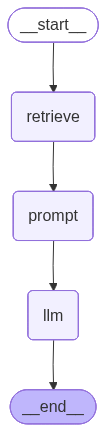

In [17]:
# mermaid_diagram = graph.get_graph().draw_mermaid()  # Mermaid text is great for version control diffs.
# print(mermaid_diagram)

# with open("langgraph_rag.mmd", "w", encoding="utf-8") as f:  # Persist textual diagram for docs.
#     f.write(mermaid_diagram)

mermaid_png = graph.get_graph().draw_mermaid_png()  # Binary PNG variant renders nicely inline.
with open("langgraph_rag.png", "wb") as f:  # Save so it can be embedded elsewhere (e.g., README).
    f.write(mermaid_png)

display(Image(mermaid_png))  # Show the actual graph picture right below the cell, as requested.


## Key Differences vs LangChain Runnable Pipeline
- **State visibility:** Every node returns the typed `RAGState`, so you can tap into intermediate data without rewiring the chain.
- **Branching readiness:** Adding guardrails, retries, or evaluator branches becomes an edge change instead of rewriting the pipeline.
- **Shared components:** Loaders, splitters, embeddings, and FAISS stay identical; LangGraph just replaces the orchestration layer.
- **LLM execution:** We still call Ollama, but it now sits behind a named node (`llm`). This makes it easy to swap with a guard or reflection node later.
